# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

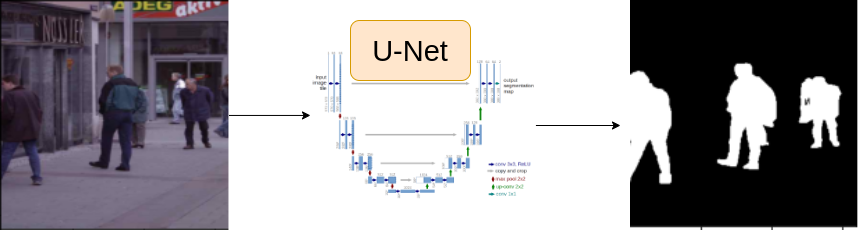

# Some Common Imports

In [63]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [64]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [65]:
csv_file = "/content/Human-Segmentation-Dataset-master/train.csv"
data = "/content"

In [98]:
batch_size = 32
epochs = 30
learning_rate = 0.003
img_size = 400
device = 'cuda'
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [67]:
import random
df = pd.read_csv(csv_file)

i = random.randint(0, len(df)-1)

row = df.iloc[i]

In [68]:
image_path = row.images
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

mask_path = row.masks
mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)

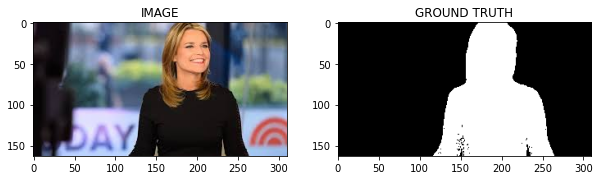

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [70]:
train, valid = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [71]:
import albumentations as a

In [72]:
from albumentations.augmentations.transforms import VerticalFlip
def train_augu():
  return a.Compose([
        a.Resize(img_size, img_size),
        a.HorizontalFlip(p = 0.5),
        a.VerticalFlip(p=0.5)
  ])

def valid_augu():
    return a.Compose([
        a.Resize(img_size, img_size)
    ])

# Task 4 : Create Custom Dataset 

In [73]:
from torch.utils.data import Dataset

In [74]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augumentations):

    self.df = df
    self.augumentations = augumentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augumentations:
      data = self.augumentations(image = image, mask = mask) 
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 250.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [75]:
trainset = SegmentationDataset(train, train_augu())
validset = SegmentationDataset(valid, valid_augu())

In [76]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


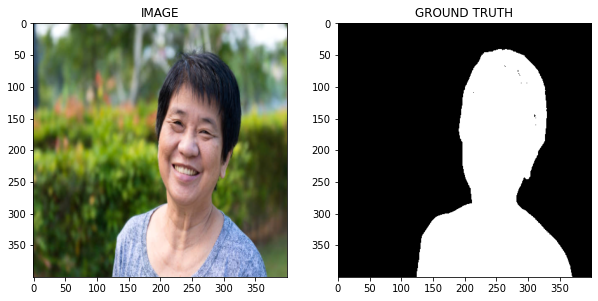

In [77]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [78]:
from torch.utils.data import DataLoader

In [79]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [80]:
for image, mask in trainloader:
  break

print(f'shape of image: {image.shape}')
print(f'shape of mask: {mask.shape}')

shape of image: torch.Size([32, 3, 400, 400])
shape of mask: torch.Size([32, 1, 400, 400])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [81]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [99]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes=1,
        activation = None
    )

    def forward(self, images, masks=None):

      logits = self.arc(images)

      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1 + loss2

      return logits

In [100]:
model = SegmentationModel()
model.to(device);

# Task 7 : Create Train and Validation Function 

In [109]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [102]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(device)
      masks = masks.to(device)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('model saved')
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1}  Train_loss: {train_loss} valid_loss: {valid_loss}')

# Task 9 : Inference

In [ ]:
idx = 10
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unseqeeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*0.1

In [ ]:
helper.show_image(image, pred_mask.detach().cpu.squeeze(0), )